# Download video frames from IBL data

This notebook streams frames 50-300 from the left camera video using get_video_frames_preload.

References:
- IBL data loading: https://int-brain-lab.github.io/iblenv/notebooks_external/one_reference.html
- Video loading: https://int-brain-lab.github.io/iblenv/notebooks_external/loading_raw_video_data.html

In [54]:
# Import required libraries
from one.api import ONE
from ibllib.io import video
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio

In [55]:
# Initialize ONE and get experiment ID
one = ONE()
pid = 'c4f6665f-8be5-476b-a6e8-d81eeae9279d'
eid, probe = one.pid2eid(pid)
print(f"Loading data for experiment: {eid}")

Loading data for experiment: e535fb62-e245-4a48-b119-88ce62a6fe67


Video URL obtained
Loading frames 50-300...
Loaded 251 frames/251


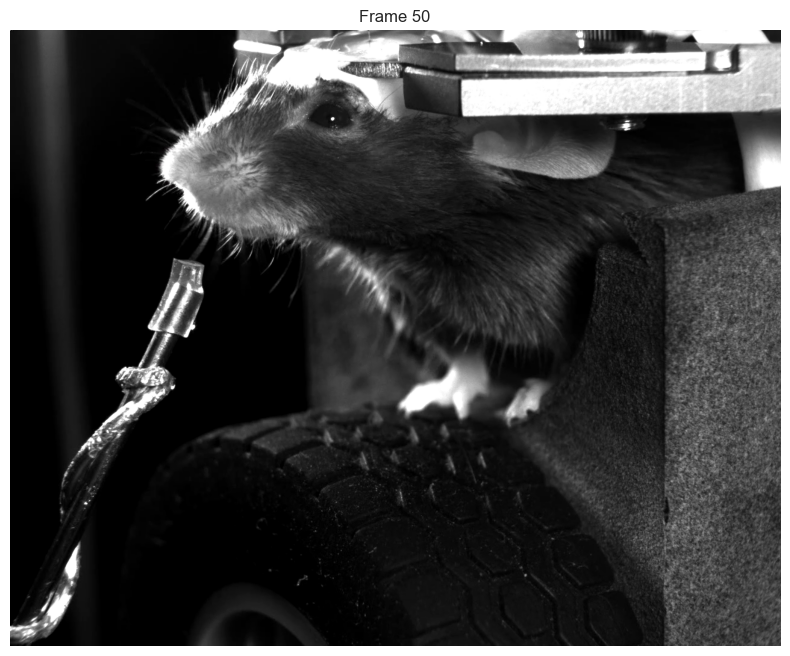

In [56]:
# Get video URL
video_url = video.url_from_eid(eid, one=one)['left']
print(f"Video URL obtained")

# Load specific frames using get_video_frames_preload
print("Loading frames 50-300...")
frame_list = list(range(50, 301))
frames = video.get_video_frames_preload(video_url, frame_list)
print(f"Loaded {len(frames)} frames")

# Display first frame as verification
plt.figure(figsize=(10, 8))
plt.imshow(frames[0])
plt.title('Frame 50')
plt.axis('off')
plt.show()

## Load DLC data

Using one.load_dataset which directly returns the DLC DataFrame.

In [57]:
# Load DLC data
print("Loading DLC data...")
dlc_df = one.load_dataset(eid, '_ibl_leftCamera.dlc')

# Print DataFrame info
print("\nDLC DataFrame info:")
print(dlc_df.info())

print("\nFirst few rows:")
print(dlc_df.head())

Loading DLC data...

DLC DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229025 entries, 0 to 229024
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   nose_tip_x                 229025 non-null  float64
 1   nose_tip_y                 229025 non-null  float64
 2   nose_tip_likelihood        229025 non-null  float64
 3   pupil_top_r_x              229025 non-null  float64
 4   pupil_top_r_y              229025 non-null  float64
 5   pupil_top_r_likelihood     229025 non-null  float64
 6   pupil_right_r_x            229025 non-null  float64
 7   pupil_right_r_y            229025 non-null  float64
 8   pupil_right_r_likelihood   229025 non-null  float64
 9   pupil_bottom_r_x           229025 non-null  float64
 10  pupil_bottom_r_y           229025 non-null  float64
 11  pupil_bottom_r_likelihood  229025 non-null  float64
 12  pupil_left_r_x             229025 non-null  f

## Create GIF with paw tracking overlay

In [58]:
def add_paw_dots(frame, dlc_frame):
    """Add large red dots for paw positions on a single frame"""
    # Make a copy of the frame
    frame_overlay = frame.copy()
    
    # Resize frame to reduce file size
    scale = 0.5
    width = int(frame_overlay.shape[1] * scale)
    height = int(frame_overlay.shape[0] * scale)
    frame_overlay = cv2.resize(frame_overlay, (width, height))
    
    # Get paw columns (any column with 'paw' in the name)
    paw_columns = [col for col in dlc_df.columns if 'paw' in col.lower()]
    
    # Add red dots for each paw position
    for col in paw_columns:
        if 'x' in col and 'likelihood' not in col:
            # Get x, y coordinates and scale them
            x = int(dlc_frame[col] * scale)
            y = int(dlc_frame[col.replace('x', 'y')] * scale)
            
            # Draw large red dot
            cv2.circle(frame_overlay, (x, y), radius=8, color=(255, 0, 0), thickness=-1)
    
    return frame_overlay

Adding paw tracking overlay...
Created all overlay frames


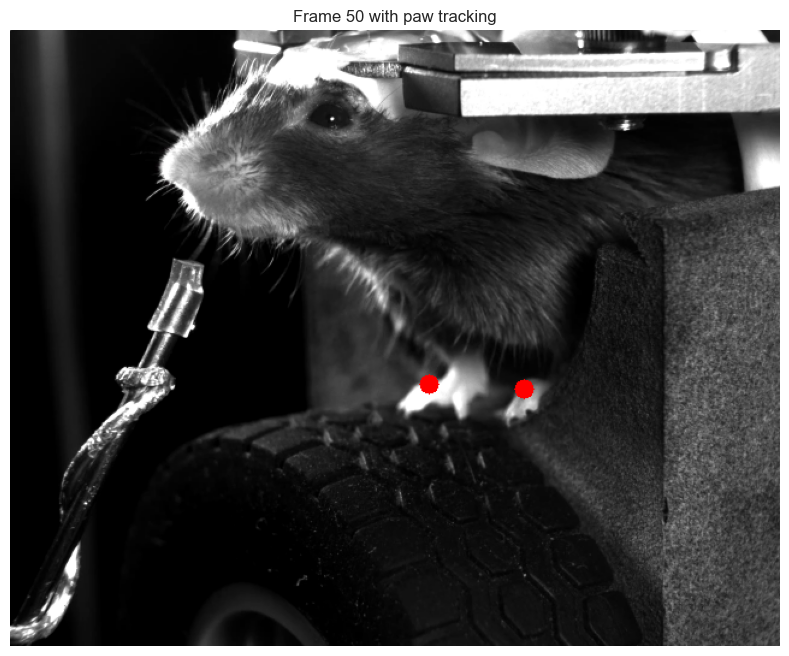

In [59]:
# Create frames with paw tracking overlay
print("Adding paw tracking overlay...")
frames_with_overlay = []

for i, frame in enumerate(frames):
    frame_idx = frame_list[i]
    frame_with_dots = add_paw_dots(frame, dlc_df.iloc[frame_idx])
    frames_with_overlay.append(frame_with_dots)

print("Created all overlay frames")

# Display first frame with overlay
plt.figure(figsize=(12, 8))
plt.imshow(frames_with_overlay[0])
plt.title('Frame 50 with paw tracking')
plt.axis('off')
plt.show()

In [60]:
# Save as optimized GIF
output_path = 'paw_tracking.gif'
fps = 30  # Standard video framerate

print("Saving GIF...")
# Save with lower quality to reduce file size
imageio.mimsave(output_path, frames_with_overlay, fps=fps, optimize=True, subrectangles=True)

# Print file size
file_size_mb = Path(output_path).stat().st_size / (1024 * 1024)
print(f"Saved to {output_path} ({file_size_mb:.1f} MB)")

# Clean up
del frames_with_overlay

Saving GIF...
Saved to paw_tracking.gif (58.0 MB)
